# Analysis of Fashion data

## Overview
This [dataset](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/data) comes from Kaggle and details purchase history from the popular clothing store H&M from September 20, 2018 to September 22, 2020. We will use this data to:
1. analyze purchase and clothing trends.
2. provide outfit recommendations to repeat customers of H&M.

## Business Problem
This analysis is great for H&M and other retailers to enhance customer engagement and drive sales leverage purchase data.
- Personalized Recommendations: Retailers can provide outfit suggestions based on a fashion trends and purchase history to increase cross-selling opportunities.
- Inventory Management: Identify short and long-term trends to optimize stock -- reducing overstock and anticipating customer demand for popular products.
- Customer Retention: Insights from purchase behavior can be used to target customers with campaigns and deals on trendy items.

## Data Understanding
There are 3 datasets we will explore. `articles.csv` has descriptive data on different articles of clothing sold at H&M, `customers.csv` has metadata on H&M customers, and `transactions_train.csv` is our training data for our model and contains data on each transaction within the two-year timeframe described above.

### Loading the datasets

In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import f_oneway, ttest_ind
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import helper

# to get the newest version of helper
import importlib
importlib.reload(helper)

<module 'helper' from '/Users/macbook/Documents/Flatiron/Cohort-Repos/assessments/phase4-project/fashion-recommendations/notebooks/helper.py'>

In [10]:
# loading in the article data
articles_df = pd.read_csv("../data/articles.csv")

articles_df.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [11]:
articles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int64 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null  object
 12  perceived_colour_master_id    105542 non-null  int64 
 13 

This dataframe holds the information for all the product details of an article of clothing.

The only null values are in `detail_desc`, so we can handle that below.

In [12]:
articles_df.describe()

,article_id,product_code,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_group_no,section_no,garment_group_no
count,1.055420e+05,105542.000000,105542.000000,1.055420e+05,105542.000000,105542.000000,105542.000000,105542.000000,105542.000000,105542.000000,105542.000000
mean,6.984246e+08,698424.563378,234.861875,1.009515e+06,32.233822,3.206183,7.807972,4532.777833,3.171534,42.664219,1010.438290
std,1.284624e+08,128462.384432,75.049308,2.241359e+04,28.086154,1.563839,5.376727,2712.692011,4.353234,23.260105,6.731023
min,1.087750e+08,108775.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.000000,1201.000000,1.000000,2.000000,1001.000000
25%,6.169925e+08,616992.500000,252.000000,1.010008e+06,9.000000,2.000000,4.000000,1676.000000,1.000000,20.000000,1005.000000
50%,7.022130e+08,702213.000000,259.000000,1.010016e+06,14.000000,4.000000,5.000000,4222.000000,2.000000,46.000000,1009.000000
75%,7.967030e+08,796703.000000,272.000000,1.010016e+06,52.000000,4.000000,11.000000,7389.000000,4.000000,61.000000,1017.000000
max,9.594610e+08,959461.000000,762.000000,1.010029e+06,93.000000,7.000000,20.000000,9989.000000,26.000000,97.000000,1025.000000


In [13]:
# loading in customer data
customer_df = pd.read_csv("../data/customers.csv")

customer_df.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [14]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   customer_id             1371980 non-null  object 
 1   FN                      476930 non-null   float64
 2   Active                  464404 non-null   float64
 3   club_member_status      1365918 non-null  object 
 4   fashion_news_frequency  1355969 non-null  object 
 5   age                     1356119 non-null  float64
 6   postal_code             1371980 non-null  object 
dtypes: float64(3), object(4)
memory usage: 73.3+ MB


This dataframe has the information of H&M customers. We may not need a lot of this information, so we will drop most of the columns except for age and postal_code in the next section.

In [15]:
# load in transactions training data
# we will use this data to train our model later
transactions_df = pd.read_csv("../data/transactions_train.csv")

transactions_df.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [16]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   t_dat             object 
 1   customer_id       object 
 2   article_id        int64  
 3   price             float64
 4   sales_channel_id  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.2+ GB


In [17]:
transactions_df.isna().sum()

t_dat               0
customer_id         0
article_id          0
price               0
sales_channel_id    0
dtype: int64

No null values to clean in the transactions data!

### Data Cleaning & Feature Engineering

`articles_df`:
- The only null values are in `detail_desc`, so we can handle that below.

In [18]:
# look at null values in detail_desc inside articles_df
articles_df[articles_df["detail_desc"].isna()]

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
1467,351332007,351332,Marshall Lace up Top,252,Sweater,Garment Upper body,1010018,Treatment,7,Grey,...,Jersey Fancy DS,D,Divided,2,Divided,58,Divided Selected,1005,Jersey Fancy,NaN
2644,420049002,420049,OL TAGE PQ,87,Boots,Shoes,1010016,Solid,13,Beige,...,Premium Quality,C,Ladies Accessories,1,Ladieswear,64,Womens Shoes,1020,Shoes,NaN
2645,420049003,420049,OL TAGE PQ,87,Boots,Shoes,1010016,Solid,23,Dark Yellow,...,Premium Quality,C,Ladies Accessories,1,Ladieswear,64,Womens Shoes,1020,Shoes,NaN
2742,426199002,426199,Ellen Shortie Daisy Low 3p,286,Underwear bottom,Underwear,1010016,Solid,9,Black,...,Casual Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear",NaN
2743,426199010,426199,Ellen Shortie Daisy Low 3p,286,Underwear bottom,Underwear,1010017,Stripe,8,Dark Grey,...,Casual Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67838,752458001,752458,Poissy boho dress,265,Dress,Garment Full body,1010007,Embroidery,10,White,...,Dress,A,Ladieswear,1,Ladieswear,6,Womens Casual,1013,Dresses Ladies,NaN
72720,768842001,768842,Andrews set,270,Garment Set,Garment Full body,1010017,Stripe,10,White,...,Baby Boy Woven,G,Baby Sizes 50-98,4,Baby/Children,41,Baby Boy,1006,Woven/Jersey/Knitted mix Baby,NaN
72721,768842004,768842,Andrews set,270,Garment Set,Garment Full body,1010004,Check,73,Dark Blue,...,Baby Boy Woven,G,Baby Sizes 50-98,4,Baby/Children,41,Baby Boy,1006,Woven/Jersey/Knitted mix Baby,NaN
93144,856985001,856985,Pogo rope,67,Belt,Accessories,1010016,Solid,12,Light Beige,...,Belts,C,Ladies Accessories,1,Ladieswear,65,Womens Big accessories,1019,Accessories,NaN


In [19]:
# fill empty detail_desc with "No Detailed description"
articles_df["detail_desc"] = articles_df["detail_desc"].fillna("No Detailed Description")

articles_df[articles_df["detail_desc"].isna()]

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc


`customers_df`:
- drop all columns except for `customer_id`, `age` and `postal_code`

In [20]:
customer_df.columns

Index(['customer_id', 'FN', 'Active', 'club_member_status',
       'fashion_news_frequency', 'age', 'postal_code'],
      dtype='object')

In [21]:
customer_df = customer_df.drop(columns=["FN", "Active", "club_member_status", "fashion_news_frequency"])
customer_df.head()

,customer_id,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


`transactions_df`:
- filter the data to the last 2 months of data only to reduce data size (August 1, 2020 - September 30, 2020)

In [22]:
# get last 2 months of transaction data
newest_trans_df = transactions_df[transactions_df["t_dat"] >= "2020-08-01"]

newest_trans_df.count()

t_dat               2035461
customer_id         2035461
article_id          2035461
price               2035461
sales_channel_id    2035461
dtype: int64

Even with this reduction, we still have 2,035,461 rows!

## Analysis

### Description Analysis

#### What were the 5 most expensive items sold in the last two months?

In [23]:
exp_products = newest_trans_df[["article_id", "price"]].sort_values(by=["price"], ascending=False)
exp_article_ids = exp_products["article_id"].unique()[:5]

articles_df[articles_df["article_id"].isin(exp_article_ids)][["article_id", "prod_name"]]

,article_id,prod_name
75173,780031001,PS FI LEATHER LEGGINGS
75176,780031004,PQ FI LEATHER LEGGINGS
103842,916300001,PQ OLGA LEATHER DRESS
103843,916300002,PQ OLGA LEATHER DRESS
103981,917509001,PQ BODEN LEATHER BLOUSE


Leather seems to be the common theme of the most expensive products sold in the last 2 months.

#### What is the number of articles sold by H&M in each product category?

In [24]:
articles_df.groupby(by="product_group_name")["article_id"].count().sort_values(ascending=False)

product_group_name
Garment Upper body       42741
Garment Lower body       19812
Garment Full body        13292
Accessories              11158
Underwear                 5490
Shoes                     5283
Swimwear                  3127
Socks & Tights            2442
Nightwear                 1899
Unknown                    121
Underwear/nightwear         54
Cosmetic                    49
Bags                        25
Items                       17
Furniture                   13
Garment and Shoe care        9
Stationery                   5
Interior textile             3
Fun                          2
Name: article_id, dtype: int64

Tops (`Garment Upper body`) is the product group with the largest number of articles sold.

#### What are the 5 most popular items per category in the last two months (August 1, 2020 - September 1, 2020)?

In [25]:
# merge new transaction data with article data
art_newtrans_merge = newest_trans_df.merge(articles_df, on="article_id")

art_newtrans_merge.columns

Index(['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id',
       'product_code', 'prod_name', 'product_type_no', 'product_type_name',
       'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc'],
      dtype='object')

In [26]:
# Group by product_group_name and article_id, then count the number of occurrences
popularity = art_newtrans_merge.groupby(["product_group_name", "article_id", "prod_name"]).size().reset_index(name="purchase_count").sort_values(["product_group_name", "purchase_count"], ascending=[True, False])

# Get the top 5 items for each product group
popularity.groupby("product_group_name")[["product_group_name", "prod_name", "purchase_count"]].head(5)


,product_group_name,prod_name,purchase_count
437,Accessories,Ringo hipbelt,1004
263,Accessories,Suzuki shopper,965
393,Accessories,Day tote,831
3091,Accessories,Eyelet hip,821
1055,Accessories,TILDA HIP BELT,712
...,...,...,...
34818,Unknown,SUPREME RW tights,2151
34796,Unknown,HAVANA HW tights,2038
34839,Unknown,Skinny RW Chic,1195
34866,Unknown,Vanessa,1050


#### What is the seasonal distribution of sales in 2019?
We're using 2019 data, as it's the last full year of data we have. 2020 data ends in September.

In [27]:
trans_2019 = transactions_df[(transactions_df["t_dat"] >= "2019-01-01") & (transactions_df["t_dat"] < "2020-01-01")]
trans_2019["month"] = pd.to_datetime(trans_2019["t_dat"]).dt.month
sales_dist_monthly = trans_2019["month"].value_counts().sort_index()

sales_dist_monthly

/var/folders/8g/m6zcqnnd1p36dhf35mwkv0zw0000gn/T/ipykernel_6349/2378413884.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans_2019["month"] = pd.to_datetime(trans_2019["t_dat"]).dt.month


month
1     1263471
2     1152412
3     1286750
4     1476454
5     1560319
6     1906202
7     1807494
8     1253530
9     1227178
10    1146772
11    1198033
12    1118315
Name: count, dtype: int64

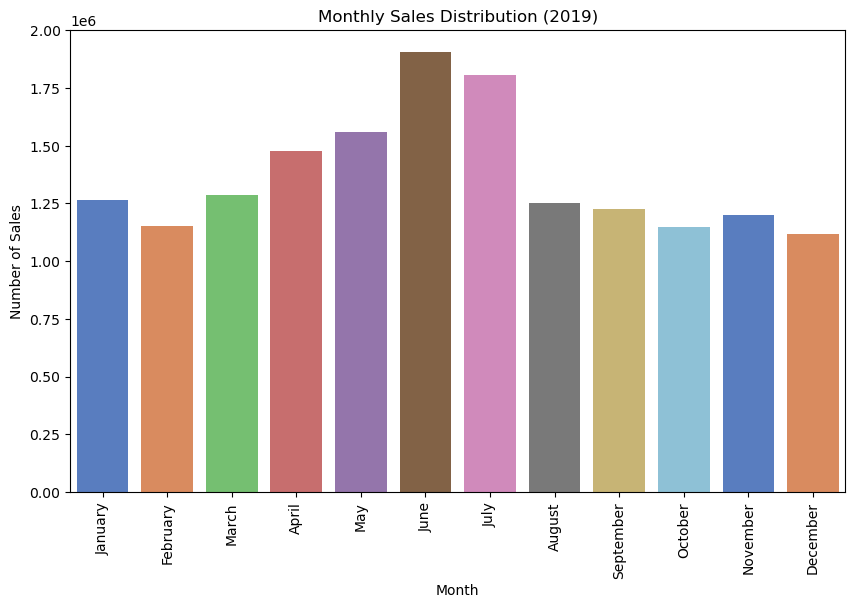

In [28]:
# Presentation Visual
plt.figure(figsize=(10, 6))

sns.barplot(x=sales_dist_monthly.index, y=sales_dist_monthly.values, hue=sales_dist_monthly.index, legend=False, palette="muted")
plt.title("Monthly Sales Distribution (2019)")
plt.xlabel("Month")
plt.ylabel("Number of Sales")
plt.xticks([0, 1, 2, 3, 4, 5, 6,
            7, 8, 9, 10, 11],
            ["January", "February", "March", "April", "May", "June", "July",
            "August", "September", "October", "November", "December"],
            rotation=90)

plt.show()

June and July have the highest sales of the year, with October and December being the months with the lowest sales.

#### Who are the top 5 customers in the last 2 months?

In [29]:
newest_trans_df["customer_id"].value_counts().head()

customer_id
a3ab708684132c6bbd3dad7aa41f9b9c7d1c95d7d5cb1a3a052905191e858566    243
4308983955108b3af43ec57f0557211e44462a5633238351fff14c8b51f16093    229
1426b606af826fa9568b6fe75629d10bb6ff7ea40f93908c43113d991e512bd5    183
4de6988c4971cfc0c6910a85a54fa8d6fb11be64b87b98c46b73821d7db07ce7    180
5df4a576fc458f3b0fd24e450f3018fc8a2d9114413f513ec26d4fcb0e0c9880    178
Name: count, dtype: int64

The customer with the most purchases in the last 2 months bought 243 pieces of clothing!

#### What is the sales distribution by article color in the last 2 months?

In [30]:
sales_dist_color = art_newtrans_merge.groupby("colour_group_name")["article_id"].count().sort_values(ascending=False)

sales_dist_color

colour_group_name
Black              705352
White              220830
Light Beige        100869
Dark Blue           90281
Beige               88408
Blue                78317
Off White           70403
Light Pink          59526
Grey                59459
Light Blue          56878
Dark Grey           51524
Greenish Khaki      42144
Dark Green          37261
Pink                37054
Light Orange        28350
Light Grey          23592
Yellowish Brown     23117
Gold                22541
Green               22482
Dark Orange         19188
Dark Beige          16821
Light Purple        16732
Dark Red            15827
Yellow              15490
Orange              14714
Red                 14403
Dark Pink           13964
Light Yellow        11884
Purple               8294
Silver               8292
Light Turquoise      7917
Greyish Beige        7913
Dark Purple          7774
Light Green          7687
Turquoise            6000
Dark Turquoise       5355
Dark Yellow          4423
Other Pink          

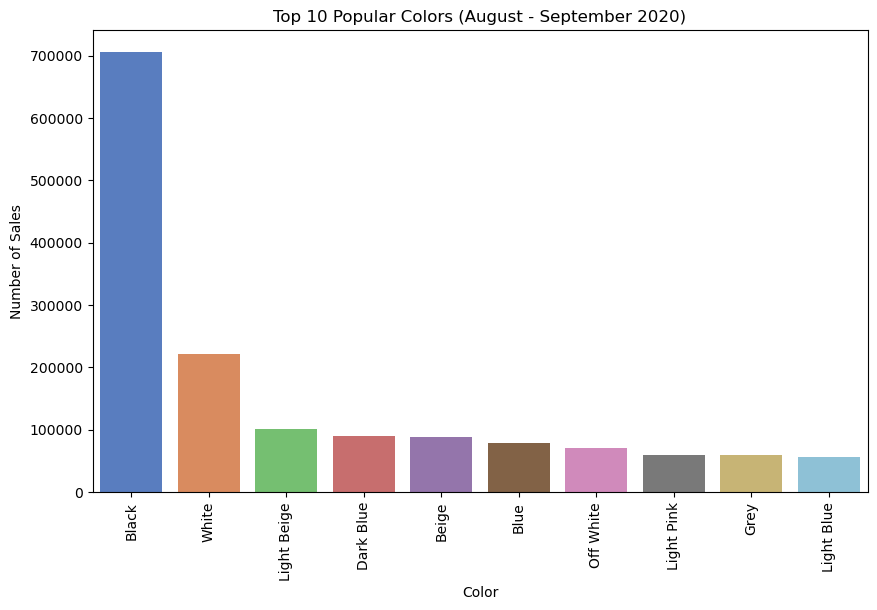

In [31]:
# Presentation Visual
# Graph the top 10 most popular colors in the last 2 months

plt.figure(figsize=(10, 6))

sns.barplot(x=sales_dist_color[:10].index, y=sales_dist_color[:10].values, hue=sales_dist_color[:10].index, legend=False, palette="muted")
plt.title("Top 10 Popular Colors (August - September 2020)")
plt.xlabel("Color")
plt.ylabel("Number of Sales")
plt.xticks(rotation=90)

plt.show()

### Inferential Questions

#### Does the average basket size differ significantly by age group?
- **Null Hypothesis**: There is no significant difference between the average basket size by age group.
- **Alternative Hypothesis**: There is a significant difference between the average basket size by age group.

In [32]:
newest_trans_df.columns

Index(['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id'], dtype='object')

In [33]:
# TODO
# Use an ANOVA test to compare different basket sizes across age groups

# get basket sizes of transactions
basket_sizes = newest_trans_df.groupby(by=["t_dat", "customer_id"])["article_id"].count().reset_index(name="basket_size")

# Merge with customer data to get age
basket_sizes = basket_sizes.merge(customer_df, on="customer_id", how="left")

# Create age groups
bins = [0, 20, 30, 40, 50, 60, 100]
labels = ["<20", "20-30", "30-40", "40-50", "50-60", "60+"]
basket_sizes["age_group"] = pd.cut(basket_sizes["age"], bins=bins, labels=labels)

In [34]:
# get basket size by age
basket_sizes_by_age = [group["basket_size"].values for _, group in basket_sizes.groupby("age_group")]

# define alpha
alpha = 0.05

# do ANOVA test
f_stat, p_value = f_oneway(*basket_sizes_by_age)

print(f"F-statistic: {f_stat}")
print(f"P-value: {p_value}")

if p_value < alpha:
    print("The average basket size differs significantly by age group.")
else:
    print("No significant difference in average basket size by age group.")

F-statistic: 1616.0130446939152
P-value: 0.0
The average basket size differs significantly by age group.


In [35]:
# Remove outliers for presentation visual purposes

# get IQR of asteroid diameter
q1 = basket_sizes["basket_size"].quantile(0.25)
q3 = basket_sizes["basket_size"].quantile(0.75)
iqr = q3 - q1

# define bounds for the outliers
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# exclude outliers from visualization data
vis_data = basket_sizes[(basket_sizes["basket_size"] >= lower_bound) &
                          (basket_sizes["basket_size"] <= upper_bound)]

/var/folders/8g/m6zcqnnd1p36dhf35mwkv0zw0000gn/T/ipykernel_6349/2768853216.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=vis_data, x="age_group", y="basket_size", palette="muted")


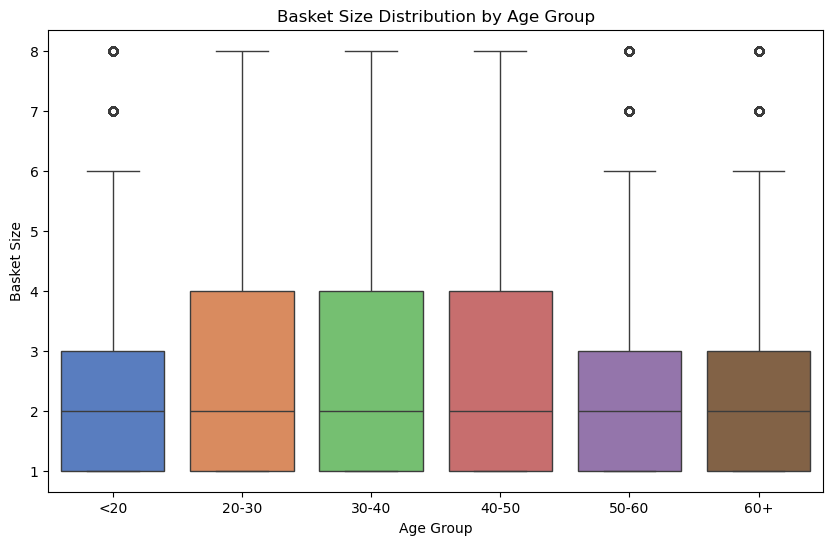

In [36]:
# Presentation Visual

plt.figure(figsize=(10, 6))

sns.boxplot(data=vis_data, x="age_group", y="basket_size", palette="muted")
plt.title("Basket Size Distribution by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Basket Size")

plt.show()

Our p-value is less than our alpha of 0.05, so we can reject the null hypothesis and say that there is a significant difference between the average basket size by age group.

#### Do customers with higher spending habits buy from more diverse categories?

In [37]:
# code df and label encode
spending_diversity_df = art_newtrans_merge[["customer_id", "price", "product_group_name"]]
helper.encode_strings(spending_diversity_df)

spending_diversity = spending_diversity_df.groupby("customer_id").agg({"price": "sum", "product_group_name": "nunique"})
spending_diversity.corr()

/Users/macbook/Documents/Flatiron/Cohort-Repos/assessments/phase4-project/fashion-recommendations/notebooks/helper.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = le.fit_transform(df[column])
/Users/macbook/Documents/Flatiron/Cohort-Repos/assessments/phase4-project/fashion-recommendations/notebooks/helper.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = le.fit_transform(df[column])


,price,product_group_name
price,1.000000,0.566303
product_group_name,0.566303,1.000000


There's a 56.6% correlation bewteen total price of a transaction and product category. Customers with higher spending habits (higher prices) appear to explore more diverse product categories, but the correlation is moderate, meaning other factors may also influence this behavior.

In [38]:
# export transactions of from last 2 months
# to a .csv to use in the next section
newest_trans_df.to_csv("../data/newest_trans_df.csv", index=False)

In [39]:
# export cleaned articles_df to a .csv to use in the next section
articles_df.to_csv("../data/articles_df.csv", index=False)

In [40]:
# export cleaned customer_df to a .csv to use in the next section
customer_df.to_csv("../data/customer_df.csv", index=False)

## Summary
- **Initial Analysis:**
    - The data was already very clean, with few null values that we filled with filler data.
    - We dropped several features that were irrelevant (eg. `club_member_status` of customers)
    - The dataset was way very large and would have made analysis and modeling slow, so we decided to filter to only the last 2 months of transactions.
- **Inferential Analysis:**
    - Rejected the null hypothesis and found there that the average basket size differs significantly by age group.
    - Found a moderate correlation (56.6%) between spending habit and diversity in products, but other factors may also influence this behavior.
- **Next Steps:**
    - Perform data preprocessing.
    - Select and train a model (classification, ensemble, ANN) to recommend an outfit based on item popularity.
    - Tune and improve the models based on performance.
    - Bonus: recommend 1 item per `product_group_name` (upper body, lower body, etc.)